In [1]:
def __clear_env():
    for key in globals().keys():
        if not key.startswith("__"):# 排除系统内建函数
            globals().pop(key)
__clear_env
import example_pendulum
import torch; torch.manual_seed(0)
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
#import torchvision
import numpy as np
import os
import matplotlib.pyplot as plt
import pickle
import csv
import datetime
from torch.autograd import Variable

In [2]:
environment = "server"
loss_log = []
params = {}
#params['learning_rate'] = trial.suggest_float('lr',0,1)
params['epochs'] = 2000
params['batch_size'] = 500
if environment == 'laptop':
    params['root_dir'] =R'C:\Users\87106\OneDrive\sindy\progress'
elif environment == 'desktop':
    params['root_dir'] = R'E:\OneDrive\sindy\progress'
elif environment == 'server':
    params['root_dir'] = R'/mnt/ssd1/stilrmy/Angle_detector/progress'
params['learning_rate'] = 1e-8

# save parameters
params['if_save'] = True
params['save_date'] = str(datetime.date.today())
params['save_ver'] = '1'
#load parameters
params['if_load'] = False
params['load_date'] = '4-7'
params['load_ver'] = '1'
#noise setting
params['adding_noise'] = True
params['noise_type'] = 'angle_noise'
params['noiselevel'] = 1e-3
PATH = os.path.join(params['root_dir'], params['save_date'],params['save_ver'])
loading_path = os.path.join(params['root_dir'], params['load_date'],params['load_ver'],'model.pth')
print(loading_path)

/mnt/ssd1/stilrmy/Angle_detector/progress/4-7/1/model.pth


In [3]:
device = 'cuda:2'
data = example_pendulum.get_pendulum_data(10,params)
image = data['x']
image_t = data['dx']
image_tt = data['ddx']
angle = data['z']
angle_t = data['dz']
angle_tt = data['ddz']
print(image.shape)

Adding noise to the pendulum data
noise_type: angle noise
(5000, 2601)


In [4]:
class angle_predict(nn.Module):
    def __init__(self):
        super(angle_predict, self).__init__()
        self.fc1 = nn.Linear(2601, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 256)
        self.fc4 = nn.Linear(256, 64)
        self.fc5 = nn.Linear(64, 2)
    def forward(self, x):
        m = nn.ReLU()
        x = self.fc1(x)
        x = m(x)
        x = self.fc2(x)
        x = m(x)
        x = self.fc3(x)
        x = m(x)
        x = self.fc4(x)
        x = m(x)
        x = self.fc5(x) 
        return x
model = angle_predict()
if params['if_load'] == True:
    model.load_state_dict(torch.load(loading_path))
model = model.to(device)

In [5]:
opt = torch.optim.Adam(model.parameters(), lr=params['learning_rate'])
for epoch in range(params['epochs']):
    loss_sum = 0
    loss_angle_sum = 0
    loss_angle_t_sum = 0
    loss_angle_tt_sum = 0
    count = 0 
    model.train()
    for i in range(len(data['z'])//params['batch_size']):
        image_temp = image[i*params['batch_size']:(i+1)*params['batch_size'],:]
        angle_temp = angle[i*params['batch_size']:(i+1)*params['batch_size']]
        angle_t_temp = angle_t[i*params['batch_size']:(i+1)*params['batch_size']]
        angle_tt_temp = angle_tt[i*params['batch_size']:(i+1)*params['batch_size']]
        for j in range(image_temp.shape[0]):
            input = Variable(torch.tensor(image_temp[j,:],dtype=torch.float32).to(device))
            pre = model.forward(input)
            angle_true = torch.tensor(angle_temp[j],dtype=torch.float32).to(device)
            angle_t_true = torch.tensor(angle_t_temp[j],dtype=torch.float32).to(device)
            angle_tt_true = torch.tensor(angle_tt_temp[j],dtype=torch.float32).to(device)
            loss_angle = torch.abs(angle_true - pre[0])
            #loss_angle_t = torch.abs(angle_t_true - pre[1])
            loss_angle_tt = torch.abs(angle_tt_true - pre[1])
            loss = loss_angle + loss_angle_tt
            loss_sum += loss
            loss_angle_sum += loss_angle
            #loss_angle_t_sum += loss_angle_t
            loss_angle_tt_sum += loss_angle_tt
            count += 1
            opt.zero_grad()
            loss.backward()
            opt.step()
        model.eval()
    loss_log.append(loss_sum.item()/count)
    if epoch % 10 == 0:
        print('epoch: ', epoch+1, 'loss: ', loss_sum.item()/count,
          '\t loss_angle:', loss_angle_sum.item()/count, 
          '\t loss_angle_tt:',loss_angle_tt_sum.item()/count)

epoch:  1 loss:  6.589221875 	 loss_angle: 0.7499439453125 	 loss_angle_tt: 5.83928046875
epoch:  11 loss:  6.58091953125 	 loss_angle: 0.745487158203125 	 loss_angle_tt: 5.835430859375
epoch:  21 loss:  6.570996875 	 loss_angle: 0.740216796875 	 loss_angle_tt: 5.8307921875
epoch:  31 loss:  6.558909375 	 loss_angle: 0.733730517578125 	 loss_angle_tt: 5.825175
epoch:  41 loss:  6.54388125 	 loss_angle: 0.725522509765625 	 loss_angle_tt: 5.818354296875
epoch:  51 loss:  6.52565703125 	 loss_angle: 0.715333544921875 	 loss_angle_tt: 5.81031875
epoch:  61 loss:  6.504628515625 	 loss_angle: 0.7034677734375 	 loss_angle_tt: 5.801158203125
epoch:  71 loss:  6.48049453125 	 loss_angle: 0.6901060546875 	 loss_angle_tt: 5.7903984375
epoch:  81 loss:  6.451196875 	 loss_angle: 0.673797705078125 	 loss_angle_tt: 5.777415625
epoch:  91 loss:  6.415979296875 	 loss_angle: 0.654089892578125 	 loss_angle_tt: 5.7618921875
epoch:  101 loss:  6.373677734375 	 loss_angle: 0.630376416015625 	 loss_angle_

KeyboardInterrupt: 

In [6]:
def saving(model,PATH):
    if os.path.exists(PATH) == False:
        os.makedirs(PATH)
    model_PATH = os.path.join(PATH, 'model.pth')
    torch.save(model.state_dict(), model_PATH)
    params_PATH = os.path.join(PATH, 'params.txt')
    with open(params_PATH, 'w') as f:
        f.write(str(params))
        f.close()
    loss_PATH = os.path.join(PATH, 'loss_log.csv')
    with open(loss_PATH, 'w') as f:
        writer = csv.writer(f)
        writer.writerow(loss_log)
    #fig_PATH = os.path.join(PATH, 'loss.png') 
    #plt.savefig(fig_PATH)
    print("data saved")
    return

In [7]:
if params['if_save'] == True:
    saving(model,PATH)

data saved


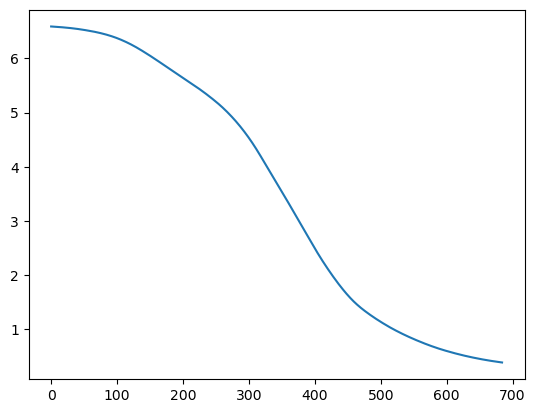

In [8]:
#plotting result
plt.plot(loss_log)
fig_PATH = os.path.join(PATH, 'loss.png') 
plt.savefig(fig_PATH, bbox_inches='tight', pad_inches = +0.1)
plt.show()

In [ ]:
print(PATH)